In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

import gc
tf.keras.backend.clear_session()
gc.collect()

0

# 各パス指定

In [2]:
# FIXED: Changed from keypoint.csv to point_history.csv
dataset = 'model/point_history_classifier/point_history.csv'
# FIXED: Changed paths to point_history_classifier
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

# 分類数設定

In [3]:
NUM_CLASSES = 5

# 入力長

In [4]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [8]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

/home/biorobotics/.pyenv/versions/3.10.13/envs/hg310/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,097 (4.29 KB)

 Trainable params: 1,097 (4.29 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, 
    verbose=1, 
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss'
)

# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20, 
    verbose=1,
    restore_best_weights=True
)

In [11]:
# モデルコンパイル
# FIXED: Added missing model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3268 - loss: 1.6052
Epoch 1: val_loss improved from None to 1.57831, saving model to model/point_history_classifier/point_history_classifier.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4033 - loss: 1.5936 - val_accuracy: 0.4116 - val_loss: 1.5783
Epoch 2/1000
20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4533 - loss: 1.5627 
Epoch 2: val_loss improved from 1.57831 to 1.52975, saving model to model/point_history_classifier/point_history_classifier.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4491 - loss: 1.5488 - val_accuracy: 0.5227 - val_loss: 1.5298
Epoch 3/1000
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4031 - loss: 1.5234 
Epoch 3: val_loss improved from 1.52975 to 1.47325, saving model to model/point_history_classifier/point_history_classifier.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4428 - loss: 1.5016 - val_accuracy: 0.5370 - val_loss: 1.4733
Epoch 4

In [13]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9509 - loss: 0.2290 
Validation Loss: 0.2290
Validation Accuracy: 0.9509


In [14]:
# Test inference on a single sample
predict_result = model.predict(np.array([X_test[0]]))
print(f'Prediction probabilities: {np.squeeze(predict_result)}')
print(f'Predicted class: {np.argmax(np.squeeze(predict_result))}')
print(f'True class: {y_test[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Prediction probabilities: [9.6662897e-01 1.1311501e-02 1.2325294e-02 9.7137978e-03 2.0388759e-05]
Predicted class: 0
True class: 0


# 混同行列

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


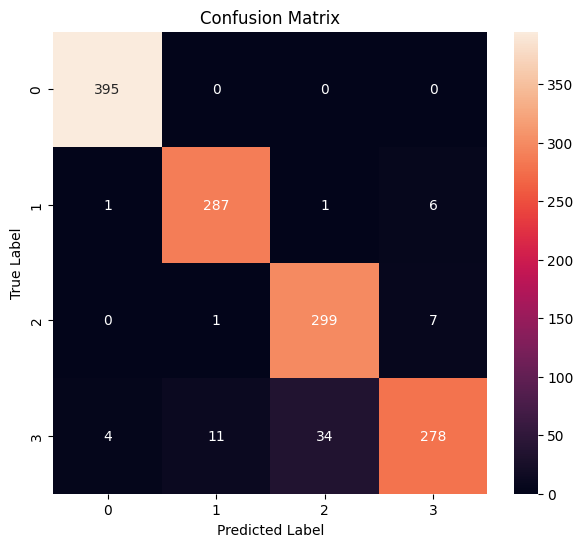

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.96      0.97      0.97       295
           2       0.90      0.97      0.93       307
           3       0.96      0.85      0.90       327

    accuracy                           0.95      1324
   macro avg       0.95      0.95      0.95      1324
weighted avg       0.95      0.95      0.95      1324



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred, zero_division=0))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [ ]:
# Save as inference-only model (without optimizer)
model.save(model_save_path, include_optimizer=False)

# Convert model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print(f'TFLite model saved to: {tflite_save_path}')

INFO:tensorflow:Assets written to: /tmp/tmprp53r13y/assets


INFO:tensorflow:Assets written to: /tmp/tmprp53r13y/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get input/output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input details:', input_details)
print('Output details:', output_details)

# 推論テスト

In [ ]:
# Test with a single sample
test_input = np.array([X_test[0]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], test_input)

In [ ]:
%%time
# Run inference
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
# Compare outputs
keras_pred = model.predict(np.array([X_test[0]]))
print('Keras prediction:', np.squeeze(keras_pred))
print('TFLite prediction:', np.squeeze(tflite_results))
print('Difference:', np.abs(np.squeeze(keras_pred) - np.squeeze(tflite_results)))